# --------------------------------
# Part 1: Data import
# --------------------------------

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# KerasNLP for BERT
import keras_nlp

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")
print(f"📦 KerasNLP version: {keras_nlp.__version__}")

✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 TensorFlow version: 2.19.1
📦 Keras version: 3.12.0
📦 KerasNLP version: 0.23.0


In [154]:
iemocap = pd.read_csv('./data/iemocapTrans.csv')

iemocap.head(10)

,_id,activation,dominance,emotion,end_time,start_time,titre,to_translate,translated,valence
0,625682441da7a5c1eaef3689,2.5,3.5,sad,6.0541,3.9987,Ses02M_impro02_F000,I don't want you to go.,Je ne veux pas que tu partes.,2.5
1,625682441da7a5c1eaef368a,3.0,4.0,sad,15.1000,7.0366,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",Je sais je sais. Je ne veux pas y aller non pl...,2.0
2,625682441da7a5c1eaef368b,2.5,4.5,sad,23.3599,15.5524,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,Tu vas me manquer aussi; Je ne sais pas ce que...,1.5
3,625682441da7a5c1eaef368c,2.5,4.0,sad,26.4151,23.5790,Ses02M_impro02_F002,I don't want to be a single mom.,Je ne veux pas être une mère célibataire.,1.5
4,625682441da7a5c1eaef368d,3.0,3.5,sad,31.4253,26.7598,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,Vous ne le serez pas. Je reviendrai; Je serai ...,3.5
5,625682441da7a5c1eaef368e,2.5,3.0,sad,32.6401,31.3058,Ses02M_impro02_F003,but,mais,2.0
6,625682441da7a5c1eaef368f,2.5,2.5,sad,33.6558,32.6800,Ses02M_impro02_M002,and,et,4.0
7,625682441da7a5c1eaef3690,3.0,4.0,sad,37.3201,33.4566,Ses02M_impro02_F004,It's dangerous; I mean how can you make sure ...,"C'est dangereux; Je veux dire, comment peux-tu...",2.0
8,625682441da7a5c1eaef3691,3.0,4.0,fru,44.4296,37.5389,Ses02M_impro02_M003,"It's- It's dangerous anywhere, honey. I mean ...","C'est... C'est dangereux n'importe où, chérie....",2.5
9,625682441da7a5c1eaef3692,4.0,4.0,sad,54.8649,44.4743,Ses02M_impro02_M004,"I'll come back we'll have, you know, some goo...","Je reviendrai, nous aurons, vous savez, de bon...",3.5


In [155]:
print(iemocap.count())
iemocap.nunique()

_id             10039
activation      10039
dominance       10039
emotion         10039
end_time        10039
start_time      10039
titre           10039
to_translate    10039
translated      10039
valence         10039
dtype: int64


_id             10039
activation         22
dominance          21
emotion            10
end_time         9369
start_time       9392
titre           10039
to_translate     8068
translated       7743
valence            21
dtype: int64

# --------------------------------
# Part 2: Data cleaning
# --------------------------------

## Remove the columns that doesn't fit the initial need

The initial dataset is about actors that are filmed with emotions, duration, intensity and so on.

As in our context we are in a consultant-client B2B meeting context transcripted by an AI like Leexi, **we will not have that much details they had with video recording**.

We will also focus on **full french meetings conversation**, so we don't need english and time-separated text.

In [156]:
iemocap.drop(
    columns=[
            "_id", # All unique
            "activation", # From video recording
            "dominance", # From video recording
            "end_time", # Not useful for us as we will use full transcript
            "start_time", # Not useful for us as we will use full transcript
            "titre", # All unique
            "to_translate", # We will focus our agent on french
            "valence", # From video recording
        ],
        inplace=True
    )

iemocap.head(10)

,emotion,translated
0,sad,Je ne veux pas que tu partes.
1,sad,Je sais je sais. Je ne veux pas y aller non pl...
2,sad,Tu vas me manquer aussi; Je ne sais pas ce que...
3,sad,Je ne veux pas être une mère célibataire.
4,sad,Vous ne le serez pas. Je reviendrai; Je serai ...
5,sad,mais
6,sad,et
7,sad,"C'est dangereux; Je veux dire, comment peux-tu..."
8,fru,"C'est... C'est dangereux n'importe où, chérie...."
9,sad,"Je reviendrai, nous aurons, vous savez, de bon..."


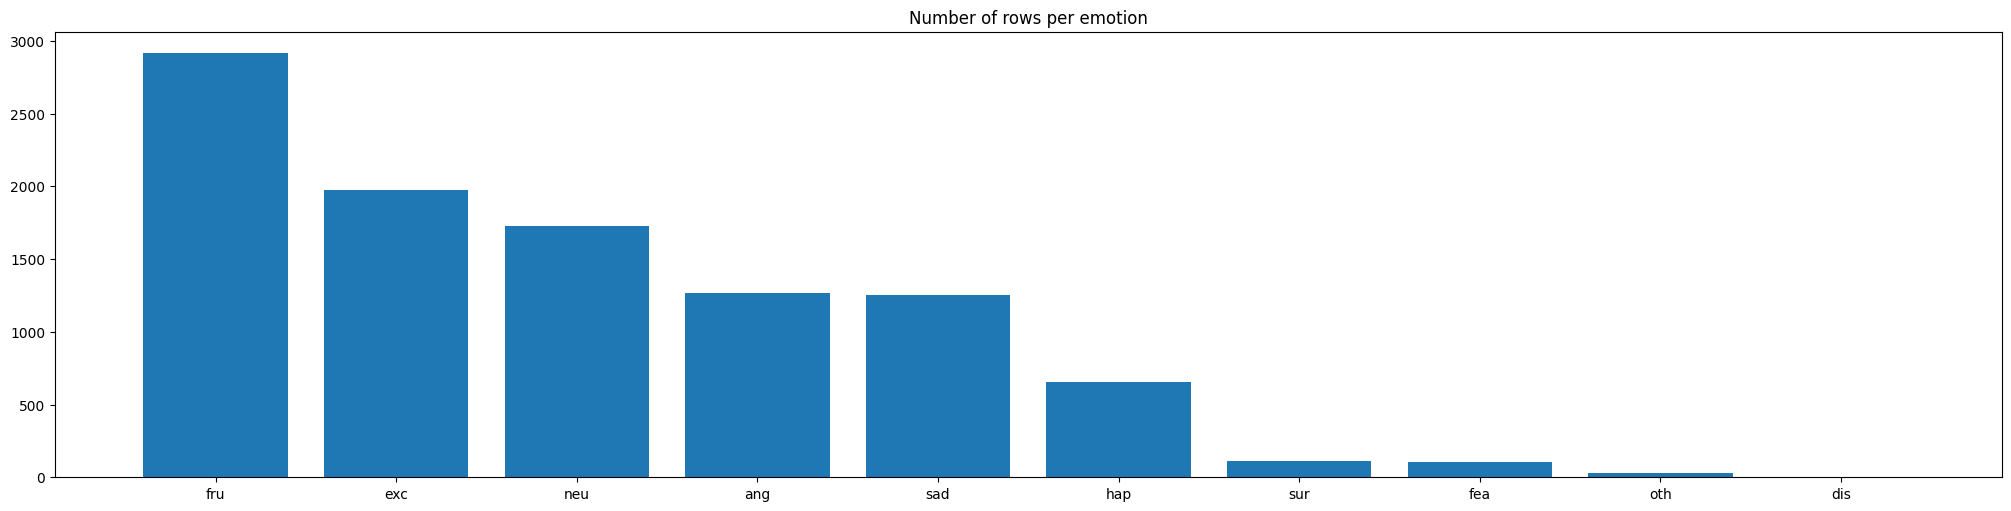

emotion
fru    2917
exc    1976
neu    1726
ang    1269
sad    1250
hap     656
sur     110
fea     107
oth      26
dis       2
Name: count, dtype: int64

In [157]:
iemocap_vcounts = iemocap['emotion'].value_counts()
fig, ax = plt.subplots(figsize=(20, 5), layout='constrained')
ax.set_title('Number of rows per emotion')
categories = iemocap_vcounts.index
ax.bar(categories, iemocap_vcounts.values)
plt.show()

iemocap['emotion'].value_counts()

In [158]:
length_dataframe = iemocap.copy()

length_dataframe['length'] = length_dataframe['translated'].str.len()

length_dataframe.head(10)

,emotion,translated,length
0,sad,Je ne veux pas que tu partes.,29
1,sad,Je sais je sais. Je ne veux pas y aller non pl...,104
2,sad,Tu vas me manquer aussi; Je ne sais pas ce que...,110
3,sad,Je ne veux pas être une mère célibataire.,41
4,sad,Vous ne le serez pas. Je reviendrai; Je serai ...,95
5,sad,mais,4
6,sad,et,2
7,sad,"C'est dangereux; Je veux dire, comment peux-tu...",67
8,fru,"C'est... C'est dangereux n'importe où, chérie....",116
9,sad,"Je reviendrai, nous aurons, vous savez, de bon...",183


length
13     62
9      49
31     44
4      43
32     41
       ..
211     1
250     1
362     1
360     1
254     1
Name: count, Length: 272, dtype: int64


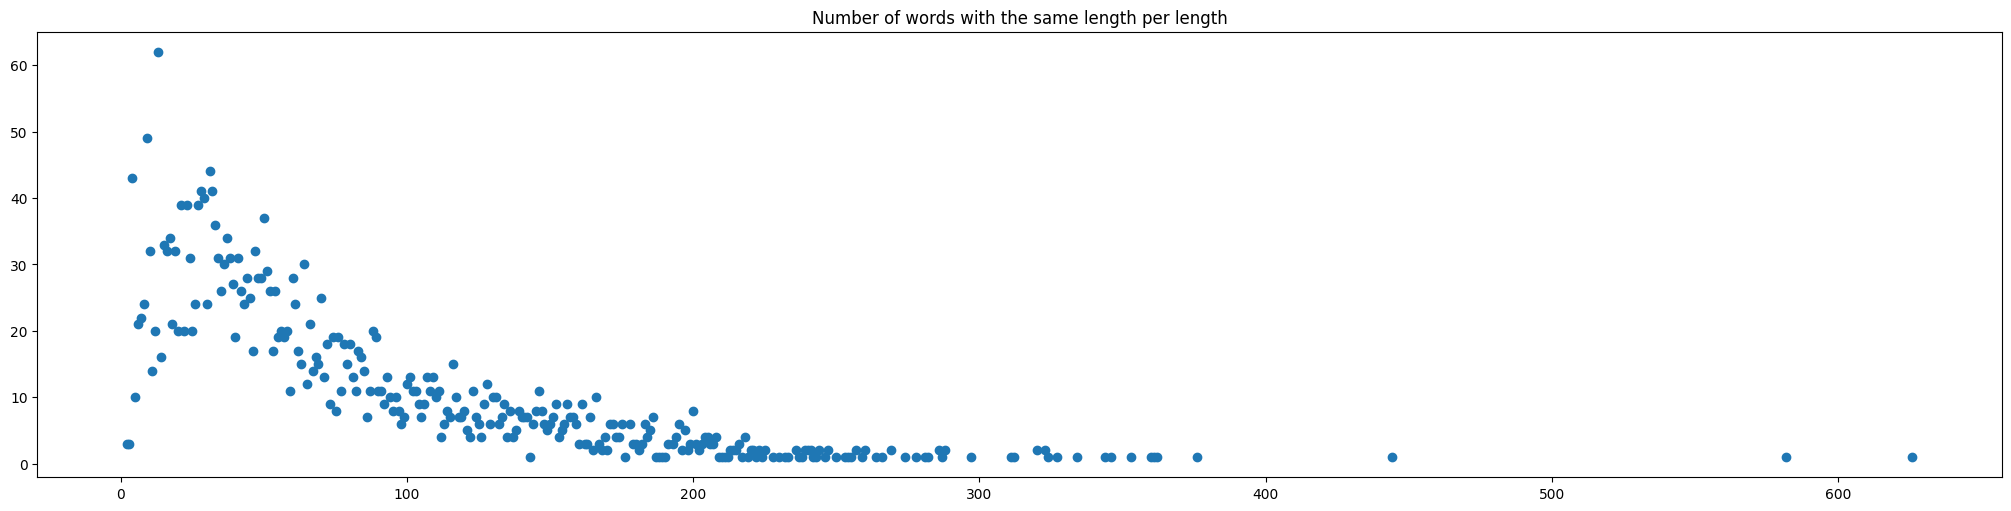

count    272.000000
mean      10.724265
std       11.185177
min        1.000000
25%        2.000000
50%        7.000000
75%       16.000000
max       62.000000
Name: count, dtype: float64

In [159]:
frustration = length_dataframe[length_dataframe['emotion'] == "fru"]

fru_len = frustration['length'].value_counts()

print(fru_len)

fig_score, ax_score = plt.subplots(figsize=(20, 5), layout='constrained')
ax_score.set_title('Number of words with the same length per length')
score_churned_x = fru_len.index
score_churned_y = fru_len.values
ax_score.plot(score_churned_x, score_churned_y, 'o')
plt.show()

fru_len.describe()

In [160]:
iemocap.isnull().sum()

emotion       0
translated    0
dtype: int64

In [161]:
frustration_short = length_dataframe[(length_dataframe['emotion'] == "fru") & (length_dataframe['length'] < 108)]

print(frustration_short.count())
print(frustration.count() - frustration_short.count())

fru_final = length_dataframe[(length_dataframe['emotion'] == "fru") & (length_dataframe['length'] > 107)]
fru_final.count()

emotion       2261
translated    2261
length        2261
dtype: int64
emotion       656
translated    656
length        656
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

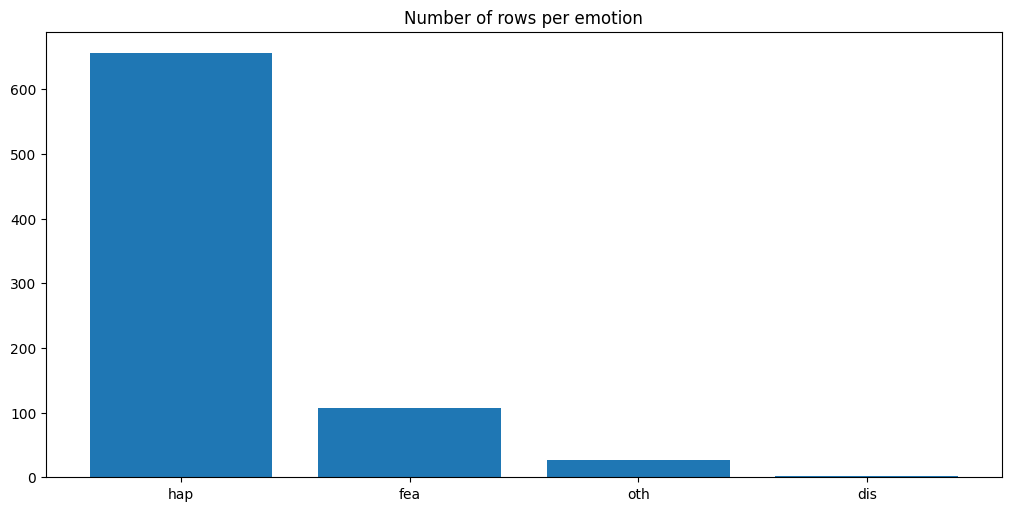

emotion
hap    656
fea    107
oth     26
dis      2
Name: count, dtype: int64

In [162]:
balanced_dataframe = length_dataframe[
    (length_dataframe['emotion'] == "hap") | 
    (length_dataframe['emotion'] == "fea") | 
    (length_dataframe['emotion'] == "oth") |
    (length_dataframe['emotion'] == "dis")
]

balanced_counts = balanced_dataframe['emotion'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.set_title('Number of rows per emotion')
categories = balanced_counts.index
ax.bar(categories, balanced_counts.values)
plt.show()

balanced_dataframe['emotion'].value_counts()

In [163]:
from sklearn.utils import resample

excited_short = length_dataframe[(length_dataframe['emotion'] == "exc") & (length_dataframe['length'] > 72)]

print(excited_short.count())

excited_final = resample(excited_short, replace=False, n_samples=656, random_state=42)
excited_final.count()

emotion       663
translated    663
length        663
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

In [164]:
neutral_short = length_dataframe[(length_dataframe['emotion'] == "neu") & (length_dataframe['length'] > 58)]

print(neutral_short.count())

neutral_final = resample(neutral_short, replace=False, n_samples=656, random_state=42)
neutral_final.count()

emotion       668
translated    668
length        668
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

In [165]:
anger_short = length_dataframe[(length_dataframe['emotion'] == "ang") & (length_dataframe['length'] > 53)]

print(anger_short.count())

anger_final = resample(anger_short, replace=False, n_samples=656, random_state=42)
anger_final.count()

emotion       657
translated    657
length        657
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

In [166]:
sadness_short = length_dataframe[(length_dataframe['emotion'] == "sad") & (length_dataframe['length'] > 41)]

print(sadness_short.count())

sadness_final = resample(sadness_short, replace=False, n_samples=656, random_state=42)
sadness_final.count()

emotion       665
translated    665
length        665
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

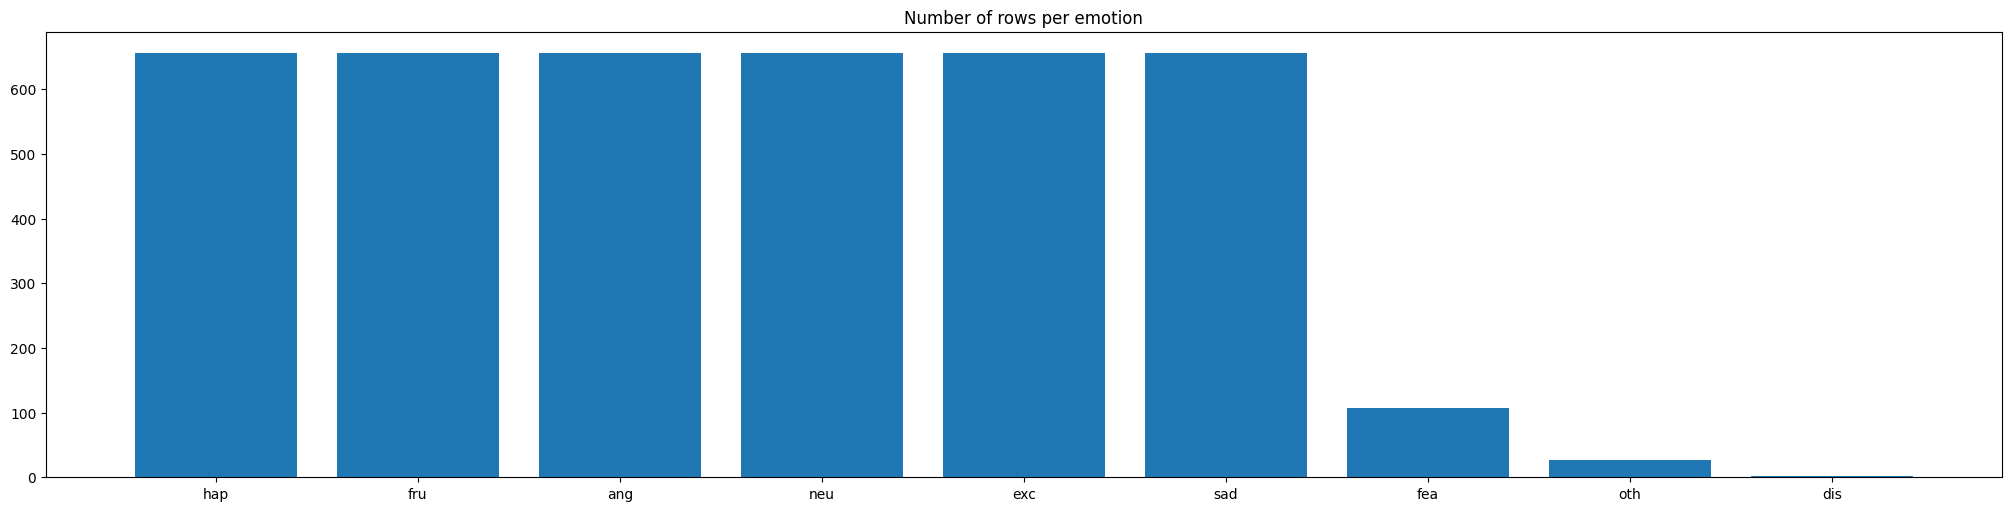

emotion       4071
translated    4071
length        4071
dtype: int64


emotion
hap    656
fru    656
ang    656
neu    656
exc    656
sad    656
fea    107
oth     26
dis      2
Name: count, dtype: int64

In [167]:
balanced_dataframe = pd.concat([balanced_dataframe, fru_final, excited_final, neutral_final, anger_final, sadness_final])

balanced_counts = balanced_dataframe['emotion'].value_counts()
fig, ax = plt.subplots(figsize=(20, 5), layout='constrained')
ax.set_title('Number of rows per emotion')
categories = balanced_counts.index
ax.bar(categories, balanced_counts.values)
plt.show()

print(balanced_dataframe.count())
balanced_dataframe['emotion'].value_counts()